# Script for preparing CORINE land use data:
Riley Luck

13.05.2025

## Imports:

In [3]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
import geopandas as gpd
from shapely.geometry import box
from rasterstats import zonal_stats
import rioxarray as rxr
import dask
import cartopy.crs as ccrs #for map projection
import cartopy.feature as cfeature #adding features to the map

## Load data:

In [28]:
wd = "/Users/rileyluck/Documents/SS_2025/ALSM/"
os.chdir(wd)

In [29]:
input_path = r"data/CORINE/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif"

In [30]:
da = rxr.open_rasterio(input_path, chunks={'x': 1000, 'y': 1000}).squeeze()  # 1. Band, 2D
da.rio.write_crs("EPSG:3035", inplace=True)
da_wgs84 = da.rio.reproject("EPSG:4326")
# Bounding Box für Deutschland in EPSG:3035 (Meter)
min_x, max_x = 5.5, 15.5
min_y, max_y = 47, 55

# Zuschneiden auf Deutschland
da_de = da_wgs84.rio.clip_box(minx=min_x, maxx=max_x, miny=min_y, maxy=max_y)

In [31]:
lookup = np.zeros(256, dtype=np.uint8)
lookup[1:12] = 1 #infrastructure /cities
lookup[12:23] = 2 #agriculture
lookup[23:35] = 3 #forest
lookup[35:40] = 4 #wetlands
lookup[40:45] = 5 #water
lookup[128] = 255 #nan

da_grouped = xr.apply_ufunc(
    lambda x: lookup[x],
    da_de.astype(np.uint8),
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.uint8]
)

In [32]:
classes = np.unique(da_grouped.values[~np.isnan(da_grouped.values)]).astype(int)  # z. B. [1, 2, ..., 48]

layers = []

# 100m → 10km = Faktor 100
agg_factor = 1

for cls in classes:
    mask = (da_grouped == cls).astype(np.float32)

    aggregated = mask.coarsen(x=agg_factor, y=agg_factor, boundary="trim").mean()

    aggregated.name = f"class_{cls}"
    layers.append(aggregated)

ds = xr.merge(layers)

ds = ds.rename({'x': 'longitude', 'y': 'latitude'})
new_names = {
    "class_1": "infrastructure",
    "class_2": "agriculture",
    "class_3": "forests",
    "class_4": "wetlands",
    "class_5": "water"
}

ds = ds.rename_vars(new_names)

In [33]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:         (longitude: 7810, latitude: 6249)
Coordinates:
  * longitude       (longitude) float64 62kB 5.5 5.501 5.502 ... 15.5 15.5 15.5
  * latitude        (latitude) float64 50kB 55.0 55.0 55.0 ... 47.0 47.0 47.0
    band            int64 8B 1
    spatial_ref     int64 8B 0
Data variables:
    infrastructure  (latitude, longitude) float32 195MB 0.0 0.0 0.0 ... 0.0 0.0
    agriculture     (latitude, longitude) float32 195MB 0.0 0.0 0.0 ... 1.0 1.0
    forests         (latitude, longitude) float32 195MB 0.0 0.0 0.0 ... 0.0 0.0
    wetlands        (latitude, longitude) float32 195MB 0.0 0.0 0.0 ... 0.0 0.0
    water           (latitude, longitude) float32 195MB 0.0 0.0 0.0 ... 0.0 0.0
    class_255       (latitude, longitude) float32 195MB 1.0 1.0 1.0 ... 0.0 0.0

In [34]:
grdc = xr.open_dataset("data/GRDC_Catchments/GRDC-Daily.nc")
catchments = gpd.read_file("data/GRDC_Catchments/stationbasins.geojson")

,grdc_no,river,station,area,altitude,lat_org,long_org,lat_pp,long_pp,dist_km,area_calc,quality,type,comment,source,geometry
0,6321100.0,NIERS,GOCH,1203.0,12.02,51.6840,6.1510,51.68417,6.15083,0.0,1407.70,Low,Automatic,Area difference 10-50% and distance <= 5 km,merit,"POLYGON ((6.2588 51.7171, 6.2588 51.7179, 6.25..."
1,6321200.0,ROER,STAH,2105.0,32.45,51.0976,6.1042,51.09750,6.10417,0.0,2159.20,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((6.0396 50.7721, 6.0388 50.7721, 6.03..."
2,6334270.0,SOHOLMER AU,SOHOLM,352.0,1.70,54.6997,9.0228,54.70000,9.02250,0.0,341.80,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((8.9671 54.6754, 8.9671 54.6754, 8.97..."
3,6334800.0,TREENE,TREIA,481.0,5.00,54.5143,9.3173,54.51417,9.31750,0.0,482.79,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((9.4962 54.5737, 9.4971 54.5737, 9.49..."
5,6335030.0,RUHR,HATTINGEN,4078.0,64.69,51.3997,7.1610,51.40000,7.16167,0.1,4122.80,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((7.1887 51.3912, 7.1887 51.3921, 7.18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,6343555.0,RAMSAUER ACHE,ILSANK,122.3,576.16,47.6200,12.9500,47.61417,12.95000,0.6,123.75,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((12.9196 47.6279, 12.9196 47.6279, 12..."
169,6343560.0,SAALACH,UNTERJETTENBERG,940.6,494.40,47.6812,12.8228,47.68120,12.82290,0.0,931.30,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((12.7875 47.7542, 12.8125 47.7542, 12..."
171,6357501.0,LUSATIAN NEISSE RIVER,GUBEN 2,4080.0,37.48,51.9692,14.7069,51.96917,14.70750,0.0,4070.00,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((14.7154 51.9513, 14.7146 51.9513, 14..."
172,6357502.0,LUSATIAN NEISSE RIVER,GOERLITZ,1621.0,175.63,51.1612,14.9932,51.16040,14.99380,0.1,1621.10,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((14.9667 51.175, 14.975 51.175, 14.97..."


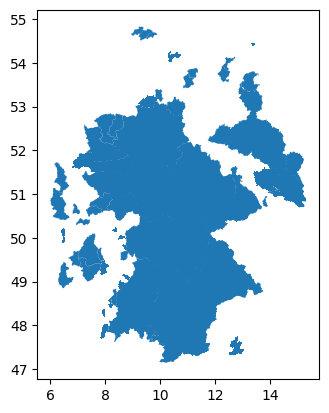

In [35]:
# limit to polygons 5.5 to 15.5 lon, 47 to 55 lat
bbox = box(5.5, 47, 15.5, 55)
bbox_gdf = gpd.GeoDataFrame([[1]], geometry=[bbox], crs="EPSG:4326") 
filtered = catchments[catchments.geometry.within(bbox)]
filtered.plot()
filtered

In [36]:
gdf_landuse = filtered.copy()
for landuse in ["infrastructure", "agriculture", "forests","wetlands","water"]:
    band = ds[landuse]
    if filtered.crs != band.rio.crs:
        filtered = filtered.to_crs(band.rio.crs)
    band.rio.to_raster("data/temp/temp.tif")
    stats = zonal_stats(
    filtered,
    "data/temp/temp.tif",
    stats=["mean"],
    geojson_out=True
    )
    gdf_with_means = gpd.GeoDataFrame.from_features(stats)
    gdf_landuse[landuse] = gdf_with_means["mean"]

In [37]:
gdf_landuse.sort_values(by="forests",ascending=False).head()

,grdc_no,river,station,area,altitude,lat_org,long_org,lat_pp,long_pp,dist_km,...,quality,type,comment,source,geometry,infrastructure,agriculture,forests,wetlands,water
136,6341500.0,TOLLENSE,KLEMPENOW,1403.0,1.00,53.7923,13.3118,53.79250,13.31167,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((13.2754 53.3663, 13.2754 53.3646, 13...",0.000000,0.000000,1.000000,0.0,0.0
146,6342600.0,DANUBE RIVER,SCHWABELWEIS,35399.0,324.49,49.0236,12.1387,49.02290,12.13960,0.1,...,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((11.8667 50.0375, 11.8708 50.0375, 11...",0.000000,0.000000,1.000000,0.0,0.0
143,6342130.0,WORNITZ,HARBURG,1578.0,403.09,48.7832,10.6924,48.78333,10.69250,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((10.1979 49.0913, 10.1954 49.0913, 10...",0.000000,0.003561,0.996439,0.0,0.0
140,6342100.0,RISS,NIEDERKIRCH,405.5,498.27,48.2386,9.8312,48.23833,9.83167,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,"POLYGON ((9.7596 48.2263, 9.7596 48.2271, 9.76...",0.015851,0.033037,0.951112,0.0,0.0
150,6342800.0,DANUBE RIVER,HOFKIRCHEN,47496.0,299.60,48.6766,13.1152,48.67710,13.11460,0.1,...,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,"POLYGON ((11.8667 50.0375, 11.8708 50.0375, 11...",0.004986,0.046643,0.948371,0.0,0.0


In [41]:
gdf_landuse.to_file('data/GRDC_Catchments/gdf_landuse.gpkg', driver='GPKG', layer='landuse')

<Axes: >

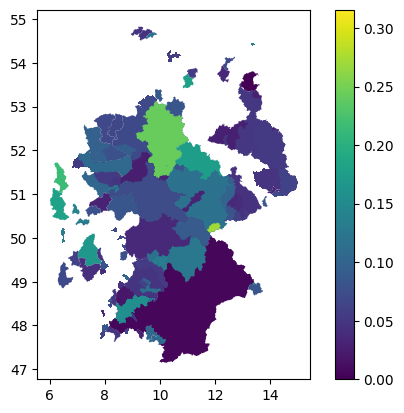

In [12]:
gdf_landuse.plot(column="infrastructure", legend=True)

<Axes: >

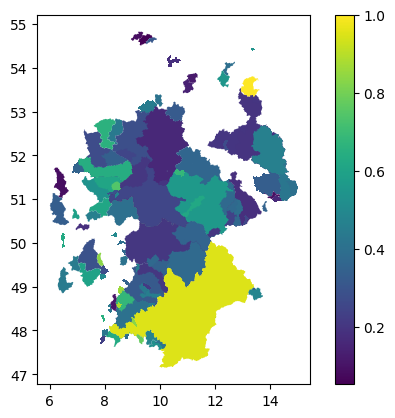

In [13]:
gdf_landuse.plot(column="forests", legend=True)

<Axes: >

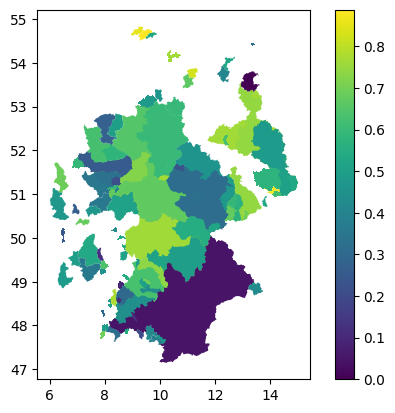

In [14]:
gdf_landuse.plot(column="agriculture", legend=True)

Now get 0.1 degree resolution data for precipitation, temperature, radiation, NDVI and runoff for the three case-study areas:
- Infrastructure station: BENTFELD
- Agriculture station: TREIA
- Forests station: KLEMPENOW

In [5]:
wd = "/Users/rileyluck/Documents/SS_2025/ALSM/"
os.chdir(wd)

In [6]:

gdf_landuse = gpd.read_file('data/GRDC_Catchments/gdf_landuse.gpkg')
gdf_landuse

,grdc_no,river,station,area,altitude,lat_org,long_org,lat_pp,long_pp,dist_km,...,quality,type,comment,source,infrastructure,agriculture,forests,wetlands,water,geometry
0,6321100.0,NIERS,GOCH,1203.0,12.02,51.6840,6.1510,51.68417,6.15083,0.0,...,Low,Automatic,Area difference 10-50% and distance <= 5 km,merit,0.215561,0.687944,0.089462,0.000000,0.007033,"MULTIPOLYGON (((6.2588 51.7171, 6.2588 51.7179..."
1,6321200.0,ROER,STAH,2105.0,32.45,51.0976,6.1042,51.09750,6.10417,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,0.182243,0.473297,0.332139,0.003841,0.008481,"MULTIPOLYGON (((6.0396 50.7721, 6.0388 50.7721..."
2,6334270.0,SOHOLMER AU,SOHOLM,352.0,1.70,54.6997,9.0228,54.70000,9.02250,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,0.048754,0.854805,0.088103,0.006822,0.001516,"MULTIPOLYGON (((8.9671 54.6754, 8.9671 54.6754..."
3,6334800.0,TREENE,TREIA,481.0,5.00,54.5143,9.3173,54.51417,9.31750,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,0.047666,0.888162,0.052989,0.005421,0.005763,"MULTIPOLYGON (((9.4962 54.5737, 9.4971 54.5737..."
4,6335030.0,RUHR,HATTINGEN,4078.0,64.69,51.3997,7.1610,51.40000,7.16167,0.1,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,0.103984,0.354998,0.532799,0.000000,0.008219,"MULTIPOLYGON (((7.1887 51.3912, 7.1887 51.3921..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,6343555.0,RAMSAUER ACHE,ILSANK,122.3,576.16,47.6200,12.9500,47.61417,12.95000,0.6,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((12.9196 47.6279, 12.9196 47.62..."
151,6343560.0,SAALACH,UNTERJETTENBERG,940.6,494.40,47.6812,12.8228,47.68120,12.82290,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((12.7875 47.7542, 12.8125 47.75..."
152,6357501.0,LUSATIAN NEISSE RIVER,GUBEN 2,4080.0,37.48,51.9692,14.7069,51.96917,14.70750,0.0,...,High,Automatic,Area difference <= 5% and distance <= 5 km,merit,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((14.7154 51.9513, 14.7146 51.95..."
153,6357502.0,LUSATIAN NEISSE RIVER,GOERLITZ,1621.0,175.63,51.1612,14.9932,51.16040,14.99380,0.1,...,High,Automatic,Area difference <= 5% and distance <= 5 km,hydrosheds,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((14.9667 51.175, 14.975 51.175,..."


In [7]:
# TODO: switch from 0.5 degree to 0.1 degree
temperature = xr.open_dataset('data/daily_average_temperature/temperature_2000_2022.nc').load()
precipitation = xr.open_dataset('data/total_precipitation/precipitation_2000_2022.nc').load()
radiation = xr.open_dataset('data/net_radiation/net_radiation_2000_2022.nc').load()
lai = xr.open_dataset('data/ndvi_daily_2000_2022.nc').load()

In [25]:
print(list(temperature.variables))

['time', 'x', 'y', 't2m', 'spatial_ref']


In [9]:
# 1. Open raster with rioxarray enabled
temperature = temperature.rio.write_crs("EPSG:4326")  # Set the CRS if not already present
temperature = temperature.rename({"lon":"x","lat":"y"})

In [43]:
# 2. Select the polygon of interest (e.g., first one)
polygon = gdf_landuse[gdf_landuse["station"]=="BENTFELD"]  # Keep it a GeoDataFrame

# 3. Ensure CRS match
if polygon.crs != ds.rio.crs:
    polygon = polygon.to_crs(ds.rio.crs)

# 4. Clip
clipped = temperature.rio.clip(polygon.geometry, polygon.crs)

In [21]:
print(temperature.data_vars)

Data variables:
    t2m      (time, y, x) float32 374MB nan nan nan nan ... 274.1 273.6 273.0


In [26]:
# Do for one station for each data set:
def data_to_catchment_extent(station_name,ds_dict):
    new_ds_dict = {}
    for key,ds in ds_dict.items():
        new_ds = ds.rio.write_crs("EPSG:4326") 
        if "lon" and "lat" in list(ds.variables):
            new_ds = new_ds.rename({"lon":"x","lat":"y"})
        polygon = gdf_landuse[gdf_landuse["station"]==station_name].geometry 
        if polygon.crs != new_ds.rio.crs:
            polygon = polygon.to_crs(new_ds.rio.crs)
        clipped = new_ds.rio.clip(polygon.geometry, polygon.crs)
        new_ds_dict.update({key:clipped})
    return new_ds_dict

<xarray.Dataset> Size: 900kB
Dimensions:      (time: 8329, x: 5, y: 5)
Coordinates:
  * time         (time) datetime64[ns] 67kB 2000-03-01 2000-03-02 ... 2022-12-19
  * x            (x) float64 40B 8.55 8.65 8.75 8.85 8.95
  * y            (y) float64 40B 51.85 51.75 51.65 51.55 51.45
    spatial_ref  int64 8B 0
Data variables:
    t2m          (time, y, x) float32 833kB nan nan nan 277.4 ... 276.1 nan nan
Attributes:
    title:        2 metre temperature
    version:      e1
    reference:    see:  http://apps.ecmwf.int/datasets/licences/copernicus/
    history:      created: Tue Jan 24 23:01:46 2023
    provided_by:  ECMWF/era5_land
    created_by:   uweber@bgc-jena.mpg.de

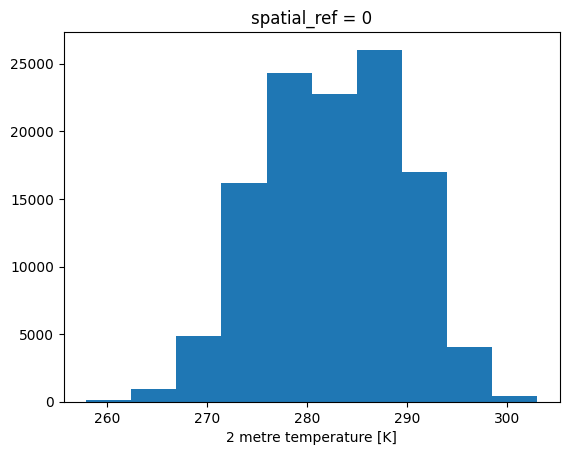

In [27]:
ds_dict = {"temperature":temperature,"precipitation":precipitation,"radiation":radiation,"ndvi":lai}
ds_dict_bentfeld = data_to_catchment_extent("BENTFELD",ds_dict)
ds_dict_treia = data_to_catchment_extent("TREIA",ds_dict)
ds_dict_klempenow = data_to_catchment_extent("KLEMPENOW",ds_dict)
ds_dict_bentfeld["temperature"].t2m.plot()
ds_dict_bentfeld["temperature"]

In [94]:
temp = ds_dict_bentfeld["temperature"]
extent = [temp.x.min(),temp.x.max(),temp.y.min(),temp.y.max()]
temp = temp.t2m.mean(dim="time")

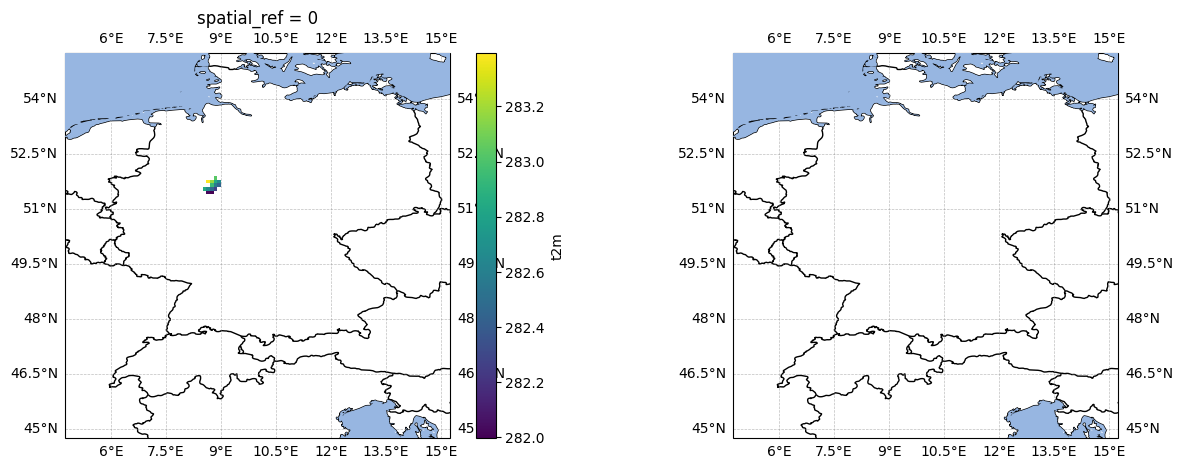

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs:
    # only add in the features you think are necessary for the map
    #add coastlines
    ax.add_feature(cfeature.COASTLINE)
    #add borders    
    ax.add_feature(cfeature.BORDERS)
    #to add oceans
    ax.add_feature(cfeature.OCEAN, zorder=100)
    #to add gridlines
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    #set extent of the map
    ax.set_extent([4.75, 15.25, 44.75, 55.25], crs=ccrs.PlateCarree())

temp.plot(ax=axs[0], transform=ccrs.PlateCarree())
axs[1]

plt.show()

In [37]:
def save_catchment(ds_dict,dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for key,ds in ds_dict.items():
        for var in ds.data_vars:
            ds[var].encoding.pop('_FillValue', None)
            ds[var].encoding.pop('missing_value', None)
        ds.to_netcdf(os.path.join(dir_path,f"{key}.nc"))

In [38]:
save_catchment(ds_dict_bentfeld,"data/catchment_timeseries/bentfeld/")

In [39]:
save_catchment(ds_dict_klempenow,"data/catchment_timeseries/klempenow/")

In [40]:
save_catchment(ds_dict_treia,"data/catchment_timeseries/treia/")

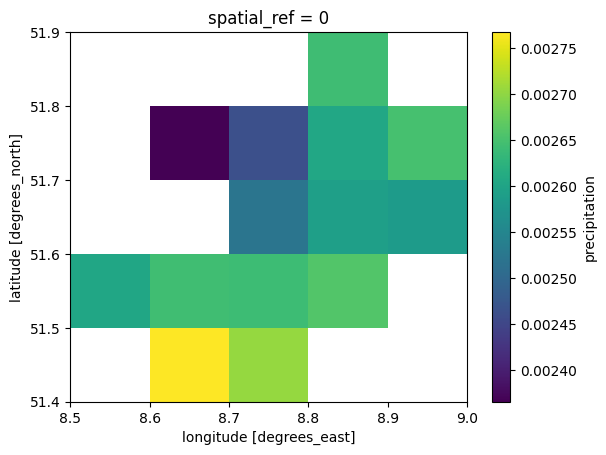

In [109]:
test = xr.open_dataset('data/catchment_timeseries/bentfeld/precipitation.nc')
test.precipitation.mean(dim="time").plot()